In [1]:
import requests
import json
from io import BytesIO
from PIL import Image
import numpy as np
import cv2

In [2]:
def generate_equally_spaced_colors(k):
    colors = []
    step = 360 / k  # Equally spaced hue step

    for i in range(k):
        hue = i * step  # Equally spaced hue values
        rgb = hsv_to_rgb(hue, 1, 1)  # Convert hue to RGB values
        scaled_rgb = tuple(
            int(val * 255) for val in rgb
        )  # Scale RGB values to 0-255 range
        colors.append(scaled_rgb)

    return colors


def hsv_to_rgb(h, s, v):
    c = v * s
    x = c * (1 - abs((h / 60) % 2 - 1))
    m = v - c

    if 0 <= h < 60:
        rgb = (c, x, 0)
    elif 60 <= h < 120:
        rgb = (x, c, 0)
    elif 120 <= h < 180:
        rgb = (0, c, x)
    elif 180 <= h < 240:
        rgb = (0, x, c)
    elif 240 <= h < 300:
        rgb = (x, 0, c)
    else:
        rgb = (c, 0, x)

    return tuple((val + m) for val in rgb)

In [3]:
with open("./cars-3.json") as f:
    data = json.load(f)

In [4]:
##Get Images that already have segmentation masks
for image in data["images"]:
    if 'segmentation' in image['tags'][0]:
        print(image['id'])

64baf8d58326400007587680
64baf8d5832640000758762c


In [5]:
##Extract first image with segmentation mask
for image in data["images"]:
    if image['id'] == "64baf8d5832640000758762c":
        break

In [6]:
req = requests.get("http://" + image["url"])
img = Image.open(BytesIO(req.content)).convert("RGB")

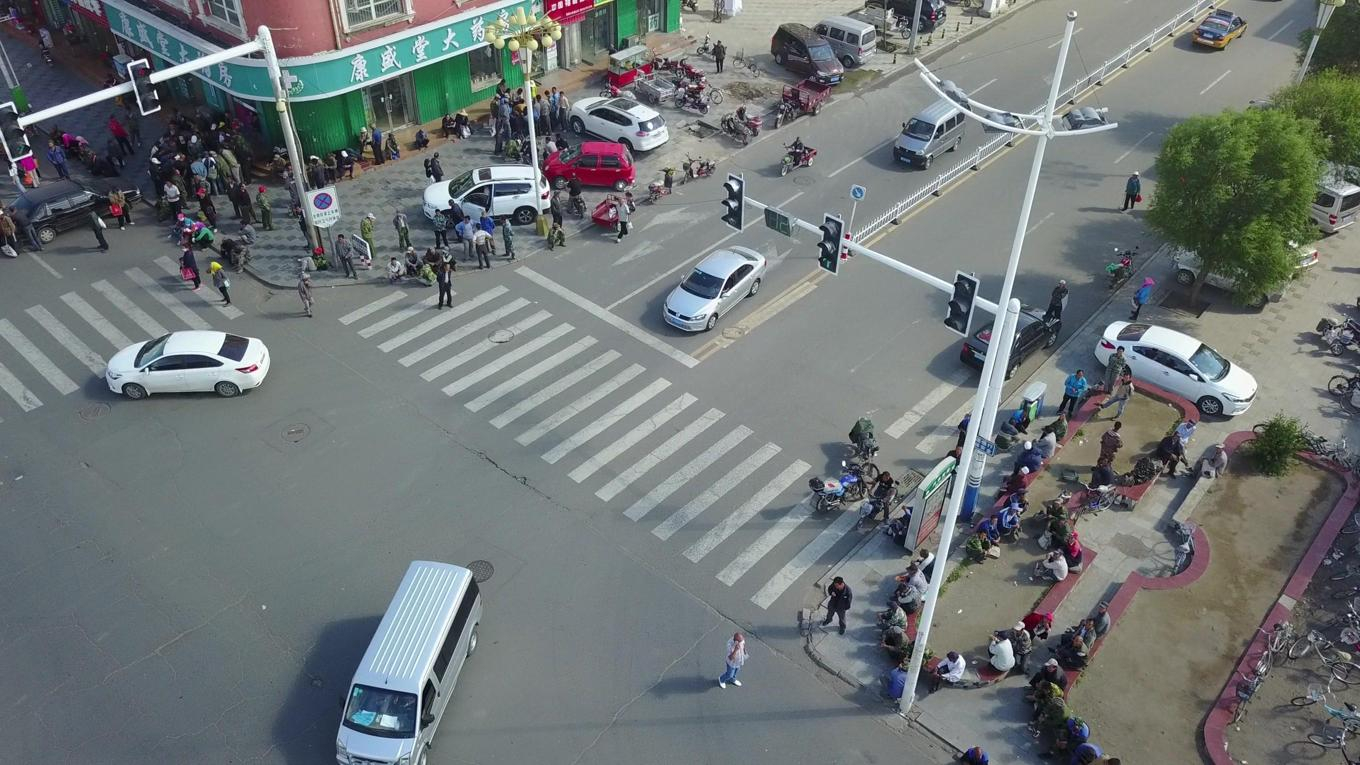

In [7]:
img

In [8]:
import numpy as np
from PIL import Image, ImageDraw

def generate_binary_mask(exterior_points, interior_points, image_size):
    # Create a blank image
    image = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(image)

    # Draw the exterior contour
    draw.polygon(exterior_points, outline=1, fill=1)

    # Draw the interior contours
    for interior_contour in interior_points:
        draw.polygon(interior_contour, outline=0, fill=0)

    # Convert the image to a binary mask (numpy array)
    binary_mask = np.array(image)

    return binary_mask


In [9]:
img.size

(1360, 765)

In [10]:
final_mask = np.zeros((img.size[1],img.size[0]))
i = 0
for tag in image['tags']:
    print(i)
    ext_points = tag['segmentation'][0]['extPoints']
    int_points = tag['segmentation'][0]['intPoints']
    int_points = [list(map(tuple,int)) for int in int_points]
    ext_points = list(map(tuple,ext_points))
    mask = generate_binary_mask(ext_points,int_points,img.size)
    indices = np.where(mask == 1)
    final_mask[indices] = 1
    i+=1
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [11]:
import matplotlib.pyplot as plt

In [12]:
img.size

(1360, 765)

In [13]:
final_mask.shape

(765, 1360)

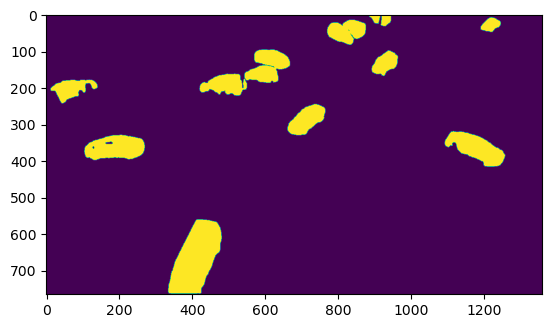

In [14]:
plt.imshow(final_mask)

In [15]:
np.unique(final_mask)

array([0., 1.])

In [16]:
import seggpt_inference

/home/ubuntu/miniconda3/envs/SegGPT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded.


In [17]:
prompt_mask = final_mask
prompt_img = img

In [18]:
import numpy as np
from PIL import Image

def split_image_into_grids(image, num_horizontal_cells, num_vertical_cells):
    width, height = image.size
    cell_width = width // num_horizontal_cells
    cell_height = height // num_vertical_cells
    grids = []
    grid_positions = []
    for y in range(0, num_vertical_cells):
        for x in range(0, num_horizontal_cells):
            grid_left = x * cell_width
            grid_right = (x + 1) * cell_width
            grid_top = y * cell_height
            grid_bottom = (y + 1) * cell_height
            
            if x == num_horizontal_cells - 1:
                grid_right = width
                
            if y == num_vertical_cells - 1:
                grid_bottom = height

            grid = image.crop((grid_left, grid_top, grid_right, grid_bottom))
            grids.append(grid)
            grid_positions.append((grid_left,grid_top))
    return grids,grid_positions


def stitch_masks(image_size, masks,grid_positions):
    width, height = image_size
    mask = np.zeros((height, width), dtype=np.uint8)

    for (x, y), m in zip(grid_positions,masks):
        mask[y:y + m.shape[0], x:x + m.shape[1]] = m

    return mask




In [ ]:
req = requests.get("http://" + data["images"][1]["url"])
test_image = Image.open(BytesIO(req.content)).convert("RGB")

In [ ]:
req = requests.get("http://" + data["images"][2]["url"])
test_image2 = Image.open(BytesIO(req.content)).convert("RGB")

In [ ]:
%%timeit -n10 -r3
output_masks,output_imgs = seggpt_inference.predict(prompt_img,prompt_mask,test_image,400)

In [ ]:
bs = 21
test_imgs = []
for i in range(bs):
    test_imgs.append(test_image2)

In [20]:
import torch

In [21]:
torch.cuda.empty_cache()

In [ ]:
# test_imgs = [test_image,test_image2,test_image2,test_image2,test_image2,test_image2,test_image2,test_image2,test_image2,test_image2,test_image2,test_image2,test_image2]

In [ ]:
%%timeit -n10 -r3
output_masks,output_imgs = seggpt_inference.predict_batch(prompt_img,prompt_mask,test_imgs,400)

In [ ]:
len(output_masks)

In [ ]:
plt.imshow(output_imgs[1])

In [ ]:
# def split_image_into_windows(image, window_size, stride):
#     width, height = image.size
#     window_width, window_height = window_size
#     windows = []
#     for y in range(0, height - window_height + 1, stride):
#         for x in range(0, width - window_width + 1, stride):
#             window = image.crop((x, y, x + window_width, y + window_height))
#             windows.append((x, y, window))
    
#     # Handle the last row and column of windows
#     last_y = height - window_height
#     last_x = width - window_width
#     if last_y > 0:
#         for x in range(0, width - window_width + 1, stride):
#             window = image.crop((x, last_y, x + window_width, height))
#             windows.append((x, last_y, window))
#     if last_x > 0:
#         for y in range(0, height - window_height + 1, stride):
#             window = image.crop((last_x, y, width, y + window_height))
#             windows.append((last_x, y, window))
#     if last_x > 0 and last_y > 0:
#         window = image.crop((last_x, last_y, width, height))
#         windows.append((last_x, last_y, window))
    
#     return windows

# def predict_instance_segmentation(predict, windows):
#     masks = []
#     for x, y, window in windows:
#         mask = predict(window)
#         masks.append((x, y, mask))
#     return masks

# def stitch_masks(image_size, masks, window_size):
#     width, height = image_size
#     window_width, window_height = window_size
#     mask = np.zeros((height, width), dtype=np.uint8)
#     counts = np.zeros((height, width), dtype=np.uint8)

#     for x, y, m in masks:
#         mask[y:y + window_height, x:x + window_width] += m
#         counts[y:y + window_height, x:x + window_width] += 1

#     # Take the majority vote for each pixel
#     mask = (mask / counts).astype(np.uint8)

#     return mask

In [ ]:
# # Example usage:
# # Assuming you have a function `predict(image)` that predicts instance segmentation masks
# # and an image named `input_image` which is a PIL image.

# # Define the number of grid cells you want to split the image into (e.g., 3x3)
# window_size = max(test_image.size)//3
# window_size = (window_size,window_size)

# # Split the PIL image into grids
# windows = split_image_into_windows(test_image,window_size,window_size[0]//2)

# # Define the predict function (assuming it takes a PIL image and returns a numpy binary mask)
# def predict(test_image):
#     # Your prediction logic here, which should return a numpy binary mask
#     # For example, you can convert the PIL image to a numpy array and perform prediction
#     out_mask,out_image = seggpt_inference.predict(prompt_img,prompt_mask,test_image,threshold = 400)
#     return out_mask

# # Predict instance segmentation masks for each grid
# masks = predict_instance_segmentation(predict, windows)
# # # Get the original image size
# image_size = test_image.size

# # # Stitch the masks together to create one segmentation mask
# result_mask = stitch_masks(image_size, masks, window_size)

In [ ]:
# # Example usage:
# # Assuming you have a function `predict(image)` that predicts instance segmentation masks
# # and an image named `input_image` which is a PIL image.

# # Define the number of grid cells you want to split the image into (e.g., 3x3)
# num_horizontal_cells = 3
# num_vertical_cells = 3

# # Split the PIL image into grids
# grids = split_image_into_grids(test_image, num_horizontal_cells, num_vertical_cells)

# # Define the predict function (assuming it takes a PIL image and returns a numpy binary mask)
# def predict(test_image):
#     # Your prediction logic here, which should return a numpy binary mask
#     # For example, you can convert the PIL image to a numpy array and perform prediction
#     out_mask,out_image = seggpt_inference.predict(prompt_img,prompt_mask,test_image,threshold = 400)
#     return out_mask

# # Predict instance segmentation masks for each grid
# masks = predict_instance_segmentation(predict, grids)

# # Get the original image size
# image_size = test_image.size

# # Stitch the masks together to create one segmentation mask
# result_mask = stitch_masks(image_size, masks, num_horizontal_cells, num_vertical_cells)

In [ ]:
# plt.imshow(result_mask)

In [ ]:
# out_mask,out_image = seggpt_inference.predict(prompt_img,prompt_mask,test_image,threshold = 400)

In [ ]:
# plt.imshow(out_mask)

In [ ]:
# plt.imshow(out_image)

In [22]:
import numpy as np
from skimage.measure import label, regionprops

def separate_masks(binary_mask, area_threshold):
    # Label connected components in the binary mask
    labeled_mask = label(binary_mask)
    
    # Get region properties of each connected component
    regions = regionprops(labeled_mask)
    
    # Initialize an empty list to store individual masks
    separate_masks = []
    
    # Iterate over each region and create a separate binary mask
    for region in regions:
        # Filter regions based on area threshold
        if region.area >= area_threshold:
            instance_mask = (labeled_mask == region.label).astype(np.uint8)
            separate_masks.append(instance_mask)
    
    return separate_masks


In [23]:
# masks = separate_masks(result_mask,10)

In [24]:
def combine_masks(masks):
    # Initialize an empty array to store the combined mask
    combined_mask = np.zeros_like(masks[0])

    # Assign unique instance IDs to each mask
    for i, mask in enumerate(masks, start=1):
        # Find the indices where the mask is True
        indices = np.where(mask == 1)

        # Assign the instance ID to those indices in the combined mask
        combined_mask[indices] = i

    return combined_mask

In [25]:
# combined_mask = combine_masks(masks)

In [26]:
# plt.imshow(combined_mask)

In [27]:
# plt.imshow(test_image)

In [28]:
# def show_segmentation_mask(mask, image):
#     # Create a copy of the original image
#     overlay = np.array(image.copy())

#     # Apply the mask as a red overlay on the image
#     red_overlay = np.zeros_like(overlay)
#     red_overlay[..., 0] = mask * 255

#     # Blend the red overlay with the original image
#     blended = cv2.addWeighted(overlay, 0.7, red_overlay, 0.3, 0)
#     return blended

In [29]:
import numpy as np
import cv2

def overlay_segmentation(image, mask):
    # Convert the PIL image to a numpy array
    image_array = np.array(image)
    num_instances = len(np.unique(mask))
    # Create a copy of the image array to draw on
    overlay = image_array.copy()

    # Define colors for each instance ID
    colors = generate_equally_spaced_colors(num_instances)

    # Draw each instance in a different color on the overlay image
    for instance_id in np.unique(mask):
        if instance_id == 0:
            continue

        # Create a binary mask for the current instance ID
        instance_mask = np.where(mask == instance_id, 255, 0).astype(np.uint8)

        # Find contours in the binary mask
        contours, _ = cv2.findContours(instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw the contours on the overlay image
        cv2.drawContours(overlay, contours, -1, colors[instance_id], thickness=cv2.FILLED)

    # Blend the overlay image with the original image
    blended_image = cv2.addWeighted(overlay, 0.5, image_array, 0.5, 0)

    # Convert the blended image back to PIL format
    blended_image_pil = Image.fromarray(blended_image)

    return blended_image_pil


In [30]:
# final_img = overlay_segmentation(test_image,combined_mask)

In [31]:
# final_img

In [32]:
# ##Now lets auto-annotate the rest of the images using the single prompt_img/mask
# for image in data['images']:
#     if image['id'] == "64b7210228151f0007746978": ##Don't predict your prompt_image
#         continue 
#     req = requests.get("http://" + image["url"])
#     test_image = Image.open(BytesIO(req.content)).convert("RGB")
#     out_mask,out_image = seggpt_inference.predict(prompt_img,prompt_mask,test_image,threshold = 20)
#     mask_overlay = show_segmentation_mask(out_mask,test_image)
#     plt.imshow(test_image)
#     plt.show()
#     plt.imshow(out_image)
#     plt.show()
#     plt.imshow(out_mask)
#     plt.show()
#     plt.imshow(mask_overlay)
#     plt.show()

In [33]:
# ##Now lets auto-annotate the rest of the images using the single prompt_img/mask
# for image in data['images']:
#     if image['id'] == "64b865e5cbdfe70007a71bb7": ##Don't predict your prompt_image
#         continue 
#     if image["url"].endswith("comundefined"): ##Matroid Backend Saving Image error
#         continue
#     req = requests.get("http://" + image["url"])
#     test_image = Image.open(BytesIO(req.content)).convert("RGB")
#     out_mask,out_image = seggpt_inference.predict(prompt_img,prompt_mask,test_image,threshold = 400)
#     masks = separate_masks(out_mask,30)
#     if len(masks) > 0:
#         combined_mask = combine_masks(masks)
#         mask_overlay = overlay_segmentation(test_image,combined_mask)
#     else:
#         mask_overlay = test_image
#     plt.imshow(test_image)
#     plt.show()
#     plt.imshow(out_image)
#     plt.show()
#     plt.imshow(out_mask)
#     plt.show()
#     plt.imshow(mask_overlay)
#     plt.show()

In [34]:
# ##Now lets auto-annotate the rest of the images using the single prompt_img/mask
# for image in data['images']:
#     if image['id'] == "64b865e5cbdfe70007a71bb7": ##Don't predict your prompt_image
#         continue 
#     if image["url"].endswith("comundefined"): ##Matroid Backend Saving Image error
#         continue
#     req = requests.get("http://" + image["url"])
#     test_image = Image.open(BytesIO(req.content)).convert("RGB")
    
    
#     num_horizontal_cells = 3
#     num_vertical_cells = 3

#     # Split the PIL image into grids
#     grids = split_image_into_grids(test_image, num_horizontal_cells, num_vertical_cells)


#     # Predict instance segmentation masks for each grid
#     masks = predict_instance_segmentation(predict, grids)

#     # Get the original image size
#     image_size = test_image.size    

#     # Stitch the masks together to create one segmentation mask
#     result_mask = stitch_masks(image_size, masks, num_horizontal_cells, num_vertical_cells)
#     masks = separate_masks(result_mask,30)
#     if len(masks) > 0:
#         combined_mask = combine_masks(masks)
#         mask_overlay = overlay_segmentation(test_image,combined_mask)
#     else:
#         mask_overlay = test_image
    
#     plt.imshow(test_image)
#     plt.show()
#     # plt.imshow(out_image)
#     # plt.show()
#     plt.imshow(result_mask)
#     plt.show()
#     plt.imshow(mask_overlay)
#     plt.show()

In [35]:

# ##Now lets auto-annotate the rest of the images using the single prompt_img/mask
# for image in data['images']:
#     if image['id'] == "64b865e5cbdfe70007a71bb7": ##Don't predict your prompt_image
#         continue 
#     if image["url"].endswith("comundefined"): ##Matroid Backend Saving Image error
#         continue
#     req = requests.get("http://" + image["url"])
#     test_image = Image.open(BytesIO(req.content)).convert("RGB")
    
    
#     num_horizontal_cells = 3
#     num_vertical_cells = 3

#     # Split the PIL image into grids
#     grids = split_image_into_grids(test_image, num_horizontal_cells, num_vertical_cells)


#     # Predict instance segmentation masks for each grid
#     masks = predict_instance_segmentation(predict, grids)

#     # Get the original image size
#     image_size = test_image.size    

#     # Stitch the masks together to create one segmentation mask
#     result_mask = stitch_masks(image_size, masks, num_horizontal_cells, num_vertical_cells)
#     out_mask,out_image = seggpt_inference.predict(prompt_img,prompt_mask,test_image,threshold = 400)
#     area_whole = total_segmented_area(out_mask)
#     area_grid = total_segmented_area(result_mask)
#     if area_whole > area_grid:
#         masks = separate_masks(out_mask,30)
#     else:
#         masks = separate_masks(result_mask,30)
#     if len(masks) > 0:
#         combined_mask = combine_masks(masks)
#         mask_overlay = overlay_segmentation(test_image,combined_mask)
#     else:
#         mask_overlay = test_image
    
#     plt.imshow(test_image)
#     plt.show()
#     # plt.imshow(out_image)
#     # plt.show()
#     plt.imshow(result_mask)
#     plt.show()
#     plt.imshow(mask_overlay)
#     plt.show()

In [36]:
# ##Now lets auto-annotate the rest of the images using the single prompt_img/mask
# for image in data['images']:
#     if image['id'] == "64b865e5cbdfe70007a71bb7": ##Don't predict your prompt_image
#         continue 
#     if image["url"].endswith("comundefined"): ##Matroid Backend Saving Image error
#         continue
#     req = requests.get("http://" + image["url"])
#     test_image = Image.open(BytesIO(req.content)).convert("RGB")
    
    
#     num_horizontal_cells = 4
#     num_vertical_cells = 4

#     # Split the PIL image into grids
#     grids = split_image_into_grids(test_image, num_horizontal_cells, num_vertical_cells)


#     # Predict instance segmentation masks for each grid
#     masks = predict_instance_segmentation(predict, grids)

#     # Get the original image size
#     image_size = test_image.size    

#     # Stitch the masks together to create one segmentation mask
#     result_mask = stitch_masks(image_size, masks, num_horizontal_cells, num_vertical_cells)
#     masks = separate_masks(result_mask,30)
#     if len(masks) > 0:
#         combined_mask = combine_masks(masks)
#         mask_overlay = overlay_segmentation(test_image,combined_mask)
#     else:
#         mask_overlay = test_image
    
#     plt.imshow(test_image)
#     plt.show()
#     # plt.imshow(out_image)
#     # plt.show()
#     plt.imshow(result_mask)
#     plt.show()
#     plt.imshow(mask_overlay)
#     plt.show()

In [37]:
def fuse_mask_levels(coarse_mask,fine_mask1,fine_mask2,fine_weight2 = 0.5,fine_weight1=0.3, coarse_weight = 0.2):
    combined_mask = (fine_weight2 * fine_mask2) + (fine_weight1 * fine_mask1) + (coarse_weight * coarse_mask)

        # Threshold the combined mask to obtain a binary result
    combined_mask = (combined_mask > 0.3).astype(np.uint8)
    return combined_mask


In [38]:
def total_segmented_area(mask):
    return np.sum(mask)


In [ ]:
# ##Now lets auto-annotate the rest of the images using the single prompt_img/mask
# for image in data['images']:
#     if image['id'] == "64b865e5cbdfe70007a71bb7": ##Don't predict your prompt_image
#         continue 
#     if image["url"].endswith("comundefined"): ##Matroid Backend Saving Image error
#         continue
#     req = requests.get("http://" + image["url"])
#     test_image = Image.open(BytesIO(req.content)).convert("RGB")
    
    
#     window_size = max(test_image.size)//4
#     window_size = (window_size,window_size)

#     # Split the PIL image into grids
#     windows = split_image_into_windows(test_image,window_size,window_size[0]//4)



#     # Predict instance segmentation masks for each grid
#     masks = predict_instance_segmentation(predict, windows)
#     # # Get the original image size
#     image_size = test_image.size

#     # # Stitch the masks together to create one segmentation mask
#     result_mask = stitch_masks(image_size, masks, window_size)
#     out_mask,out_image = seggpt_inference.predict(prompt_img,prompt_mask,test_image,threshold = 400)
#     area_whole = total_segmented_area(out_mask)
#     area_grid = total_segmented_area(result_mask)
#     if area_whole > area_grid:
#         masks = separate_masks(out_mask,30)
#     else:
#         masks = separate_masks(result_mask,30)
#     if len(masks) > 0:
#         combined_mask = combine_masks(masks)
#         mask_overlay = overlay_segmentation(test_image,combined_mask)
#     else:
#         mask_overlay = test_image
    
#     plt.imshow(test_image)
#     plt.show()
#     # plt.imshow(out_image)
#     # plt.show()
#     plt.imshow(result_mask)
#     plt.show()
#     plt.imshow(mask_overlay)
#     plt.show()

In [ ]:
##Multilivel!!!
##Now lets auto-annotate the rest of the images using the single prompt_img/mask
for image in data['images']:
    if image['id'] == "64baf8d5832640000758762c": ##Don't predict your prompt_image
        continue 
    if image["url"].endswith("comundefined"): ##Matroid Backend Saving Image error
        continue
    req = requests.get("http://" + image["url"])
    test_image = Image.open(BytesIO(req.content)).convert("RGB")
    image_size = test_image.size  
    ##Add Whole Image to Grids to be predicted on   
    test_grids = [test_image]
    
    num_horizontal_cells = 4
    num_vertical_cells = 4
    # Split the PIL image into grids
    grids4,grids_pos_4 = split_image_into_grids(test_image, num_horizontal_cells, num_vertical_cells)
    ##Add 4*4 Tiled Image to Grids to be predicted on   
    test_grids = test_grids + grids4
    
    num_horizontal_cells = 2
    num_vertical_cells = 2
    # Split the PIL image into grids
    grids2,grids_pos_2 = split_image_into_grids(test_image, num_horizontal_cells, num_vertical_cells)
    ##Add 2*2 Tiled Image to Grids to be predicted on 
    test_grids = test_grids + grids2
    # Predict instance segmentation masks for each grid
    masks,_ = seggpt_inference.predict_batch(prompt_img,prompt_mask,test_grids,400)
    # Stitch the masks together to create one segmentation mask
    result_mask4 = stitch_masks(image_size, masks[1:17], grids_pos_4)
    result_mask2 = stitch_masks(image_size, masks[17:], grids_pos_2)
    out_mask = masks[0]
    area_whole = total_segmented_area(out_mask)
    area_grid3 = total_segmented_area(result_mask2)
    area_grid4 = total_segmented_area(result_mask4)
    mask_levels = [out_mask,result_mask2,result_mask4]
    mask_areas = [area_whole,area_grid3,area_grid4]
    # if area_whole > area_grid:
    #     masks = separate_masks(out_mask,30)
    # else:
    #     masks = separate_masks(result_mask,30)
    ##Pick the mask at the most appropriate level
    masks = separate_masks(mask_levels[np.argmax(mask_areas)],30)
    if len(masks) > 0:
        combined_mask = combine_masks(masks)
        mask_overlay = overlay_segmentation(test_image,combined_mask)
    else:
        mask_overlay = test_image
    
    # plt.imshow(test_image)
    # plt.show()
    # plt.imshow(out_mask)
    # plt.show()
    # plt.imshow(result_mask2)
    # plt.show()
    # plt.imshow(result_mask4)
    # plt.show()
    plt.imshow(mask_overlay)
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def calculate_bounding_boxes(mask):
    """
    Calculate the bounding boxes of objects from a mask where each object has a different instance ID.

    Parameters:
        mask (numpy.ndarray): Mask where each object has a unique instance ID (integers).

    Returns:
        List: A list of bounding box tuples [(x_min, y_min, x_max, y_max)] for each object in the mask.
    """
    unique_ids = np.unique(mask)
    unique_ids = unique_ids[unique_ids != 0]  # Remove background ID (usually 0)

    bounding_boxes = []

    for obj_id in unique_ids:
        # Find indices of the object with a specific ID
        object_indices = np.where(mask == obj_id)

        # Calculate minimum and maximum coordinates along x and y axes
        x_min = np.min(object_indices[1])
        x_max = np.max(object_indices[1])
        y_min = np.min(object_indices[0])
        y_max = np.max(object_indices[0])

        bounding_boxes.append((x_min, y_min, x_max, y_max))

    return bounding_boxes


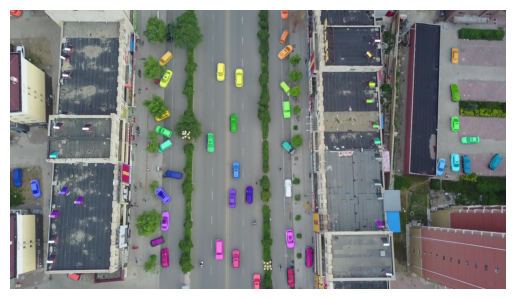

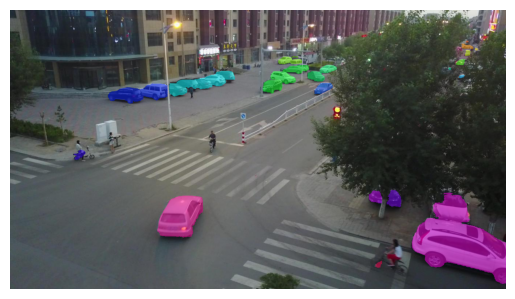

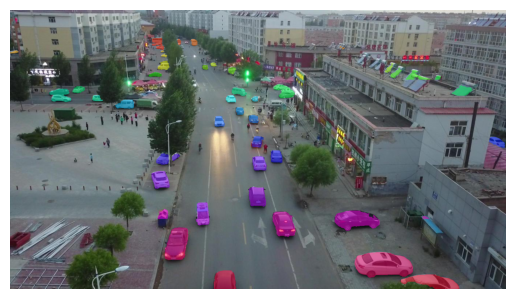

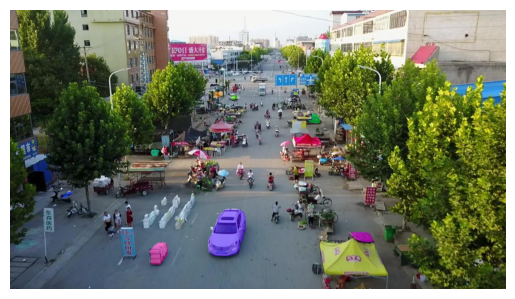

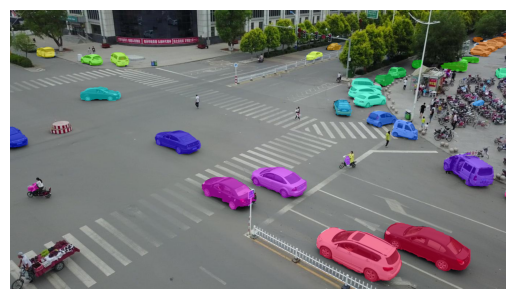

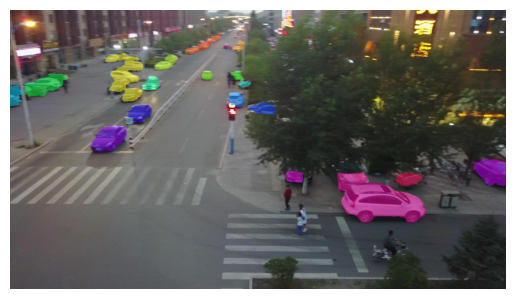

In [39]:
##Multilivel!!!
##Now lets auto-annotate the rest of the images using the single prompt_img/mask
for image in data['images']:
    if image['id'] == "64baf8d583264000075875da": ##Don't predict your prompt_image
        continue 
    if image["url"].endswith("comundefined"): ##Matroid Backend Saving Image error
        continue
    req = requests.get("http://" + image["url"])
    test_image = Image.open(BytesIO(req.content)).convert("RGB")
    combined_mask = seggpt_inference.predict_tiled(prompt_img,prompt_mask,test_image)
    if combined_mask is not None:
        # bboxes = calculate_bounding_boxes(combined_mask)
        mask_overlay = overlay_segmentation(test_image,combined_mask)
        plt.imshow(mask_overlay)
        # for (x_min,y_min,x_max,y_max) in bboxes:
        #     plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
        #                                 linewidth=0.5, edgecolor='r', facecolor='none'))
        plt.axis('off')
        plt.show()
    else:
        mask_overlay = test_image
        plt.imshow(mask_overlay)
        plt.axis('off')
        plt.show()
    
    # plt.imshow(test_image)
    # plt.show()
    # plt.imshow(out_mask)
    # plt.show()
    # plt.imshow(result_mask2)
    # plt.show()
    # plt.imshow(result_mask4)
    # plt.show()


In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch